# Ch 8. Using convolutions to generalize
---
>- 컨볼루션 이해
>- 컨볼루션 신경망 만들기
>- 커스텀 `nn.Module` 만들기
>- 모듈과 함수형 API의 차이
>- 신경망 설계시 고려할 점

### 8.1 컨볼루션
기존 모델에서 인접한 픽셀들을 들여다보도록 하는 것과 평행이동 불변성(Translation invarance)을 얻어야 한다는 것을 알았다.

먼저 인접한 픽셀의 배열 방식을 살펴보도록 하는 것을 수학적으로 나타내면 다음과 같다. 인접한 픽셀에 대한 가중치의 합을 구하는 것이다. 출력 피쳐와 출력 픽셀 위치마다 가중치 행렬을 만들어서 중심이 되는 픽셀에서 일정 거리 멀어지면 가중치가 0이 되는 방식이다.

다음으로 평행이동 불변성을 얻기 위해선 가중치 행렬 대부분을 0으로 만들고 입력에 대해 상대적으로 같은 위치에 있는 엔트리가 출력 픽셀에 동일한 영향을 줄 방법을 찾아야한다. 이처럼 이미지에 대해 평행이동 불변성을 보장하는 선형 연산이 **컨볼루션**(**Convolution**)이다.

우리가 사용할 **이산 컨볼루션**(**Discrete Convolution**)은 **커널**(**kernerl**)이라고 불리는 가중치 행렬에 스칼라 곱으로 표현된 2D 이미지에 대해 정의된다. 이 연산을 입력의 모든 이웃에 대해 수행한다.

컨볼루션 연산은 아래 그림과 같이 진행된다. 커널이 입력의 모든 위치로 이동하면서 가중치의 합을 구해 출력 이미지를 만들어낸다. 이때 동일한 커널이 전체 이미지에 대해 계속 사용된다는 점을 기억하자.

- 인접 영역에 대한 지역 연산을 할 수 있고,
- 평행이동 불변성을 가지며,
- 더 적은 파라미터를 사용한다.


![image](https://user-images.githubusercontent.com/76675506/189580319-d625c1b6-b845-4647-9337-e49cac56dcfe.png)



In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [22]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [23]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

C:\Users\soso6\miniconda3\envs\Deeplearning with PyTorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [24]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

- `nn.Conv1d`: 시계열
- `nn.Conv2d`: 이미지
- `nn.Conv3d`: 용적 데이터, 동영상

`nn.Conv2d`는 최소 입력 피처 수, 출력 피처 수, 커널 크기를 인자로 받는다.

In [25]:
conv = nn.Conv2d(3, 16, kernel_size=3).to(device='cuda') # 픽셀당 3개(RGB)의 입력 피처, 임의의 출력 피처 및 커널 크기
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

컨볼루션의 `weight`텐서는 `out_ch` X `in_ch` X `kernel` 형태로 나타난다.

In [26]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

`output`의 크기가 30x30으로 변한 것을 알 수 있다. 이는 이미지의 경계 부분에서의 작업에 따른 부작용이다. 컨볼루션 연산은 기본적으로 모든 방향에 값이 존재한다는 전제로 진행된다. 크기가 홀수인 컨볼루션 커널의 길이의 절반만큼 양쪽의 그림이 잘린다.

이를 보완할 수 있는 방법이 **패딩**(**padding**)이다.


![image](https://user-images.githubusercontent.com/76675506/189588794-986889ed-998e-4662-b8ba-84139edcbba0.png)

In [27]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0).to(device='cuda')) # B x C x H x W
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

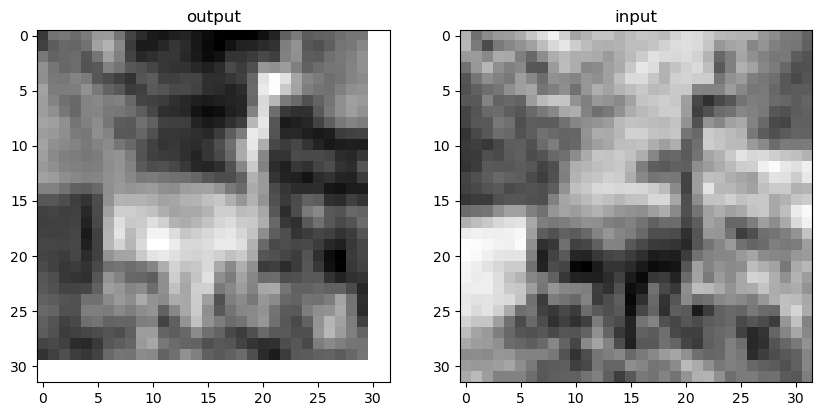

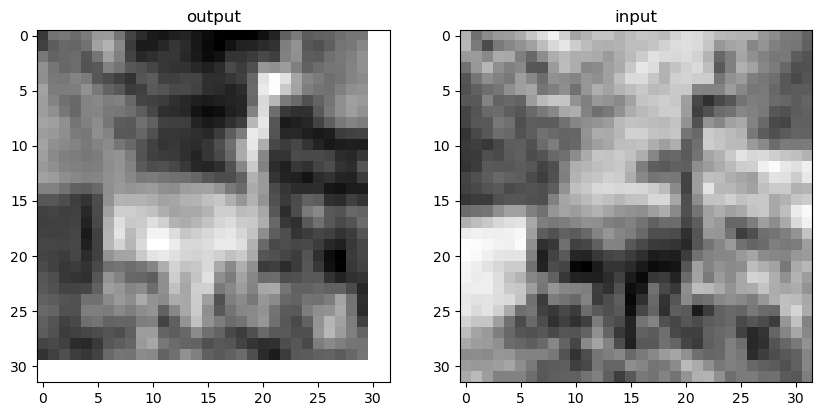

In [28]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0,0].to(device='cpu').detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

`kernel_size`가 3일 때 `padding`을 1로 지정하면 0,0 지점에서 왼쪽과 위쪽에 추가 인접 픽셀(가짜)이 만들어진다. 만약 커널 크기가 짝수라면 왼쪽과 오른쪽, 위와 아래를 각각 서로 다른 크기로 패딩해야 한다. `torch.nn.functional.pad`로 이를 구현할 수 있다. 하지만 통상 커널은 홀수 크기로 만드는 것을 추천한다.

패딩을 사용하는 이유를 정리하면 다음과 같다.
>- 이미지 크기 변경 문제를 예방할 수 있다.
>- 컨볼루션 구조 자체에 더 신경쓸 수 있다.

In [29]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### 컨볼루션으로 피쳐 찾아내기
---
가중치 값을 변경해서 어떤 일이 일어나는지 확인해볼 수 있다.

In [30]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

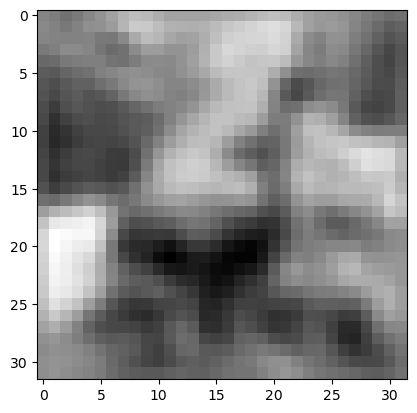

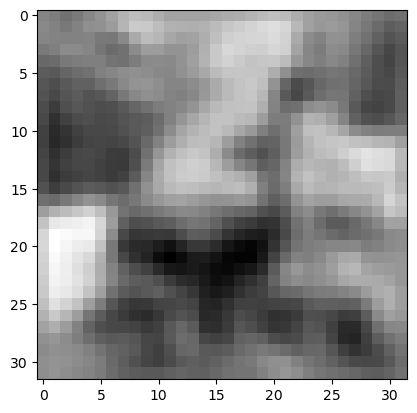

In [31]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

아래 커널 값은 오른쪽 픽셀에서 기준 픽셀의 왼쪽 픽셀을 빼는 계산을 수행한다. 만약 이미지에서 강도가 다른 두 인접한 영역 사이에서 수직 경계에 커널이 적용되면, 높은 값을 갖게 된다. 반면에 커널이 비슷한 색이나 밀도로 이뤄진 영역에서 수행됐다면 값이 0이 된다.
즉 가로로 인접한 두 영역 사이의 수직 경계를 탐색하는 역할을 한다. 결과물에서는 수직 경계가 강조된 효과를 얻을 수 있다.

이미지의 각 채널은 커널의 각 피처에 대응하게 된다. (한 채널은 평균, 다른 채널은 수직 경계선을 강조하는 경우를 생각해보자.)

In [32]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

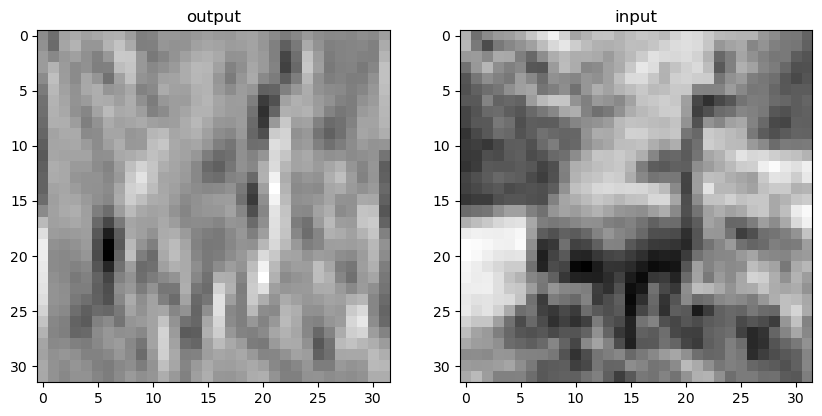

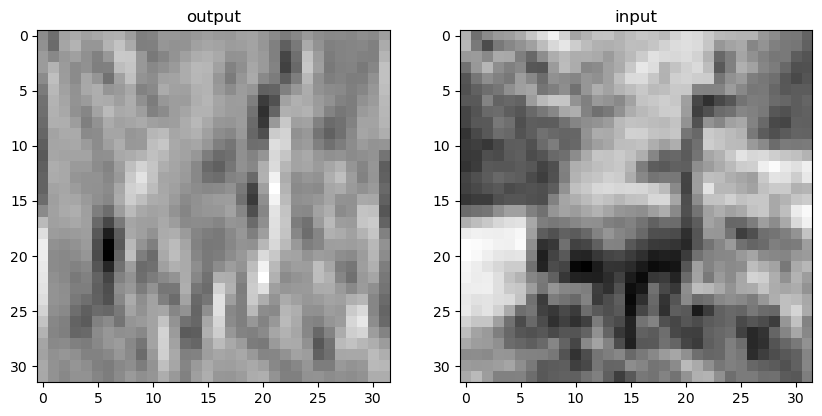

In [33]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

### 다운샘플링
---
3x3이나 5x5처럼 작은 커널을 사용한다면 큰 범위의 이미지를 인식할 때 문제가 생길 수 있다. 이를 해결하는 방법 중 하나로 다운 샘플링이 있다.
- **평균 풀링(Avarage Pooling)**: 최근에는 잘 사용하지 않는 방법
- **맥스 풀링(Max Pooling)**: 가장 많이 사용되지만 데이터의 4분의 3을 버린다는 단점이 있다. 아래 그림에 동작 원리가 나타나있다. 최댓값을 뽑는 것은 약한 신호를 버리고 살아남은 피처를 발견하는 과정으로 볼 수 있다.

- n번째 픽셀만 계산하면서 Strided convolution을 수행하는 방법: 3x4 컨볼루션을 스트라이드 2로 진행하면 이전 계층의 모든 픽셀을 포함한다. 맥스 풀링을 대체하진 못한다.


![image](https://user-images.githubusercontent.com/76675506/189616224-99f50235-2471-4b2a-8c75-280838641935.png)

In [43]:
pool = nn.MaxPool2d(2) # 풀링 연산을 수행할 인접한 영역 크기를 인자로 받는다. 2로 넣으면 이미지를 절반으로 줄이게 된다.
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

1. 8x8 이미지에 3x3 커널을 적용해서 같은 크기의 컨볼루션 출력 결과를 얻는다.
2. 출력 이미지에 대해 맥스 풀링을 적용해 4x4 크기의 이미지를 얻는다. 이 이미지에 다른 3x3 커널을 적용한다. 이 때의 커널 셋은 첫 번째 커널 셋의 피처를 받고 추가적인 피처를 추출한다.

![image](https://user-images.githubusercontent.com/76675506/189617954-258b285e-07ae-4e79-a2da-baba219c8967.png)

- 출력 픽셀의 수용필드
    - ㄹㅇㅁㄴ

아래 모델은
1. 첫 번째 컨볼루션은 3 RGB 채널을 16개의 피처를 만들어 새와 비행기에 대한 저수준의 피처를 찾아낸다.
2. 그 후 `Tanh` 활성 함수를 적용한다.
3. 위 결과로 만들어진 16채널의 32x32 이미지는 이제 첫 `MaxPool2d`를 통해 16x16 이미지로 다운샘플링된다.
4. 위 출력은 8채널 16x16 출력을 만드는 컨볼루션으로 들어간다. 이 출력은 더 높은 수준의 피처를 가지게 된다.
5. 그 후 `Tanh` 활성 함수를 거친다음
6. 8채널 8x8 출력을 위한 풀링을 거친다.
- 이 모델은 결국 NLL로 넣을 수 있는 확률값을 뽑아줘야 한다. 현재는 결과값이 멀티 채널의 2차원 피처인 상태다.

![image](https://user-images.githubusercontent.com/76675506/189625166-cdc0bcbb-79f1-48f8-9738-befe4fd1b322.png)

In [35]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), # 1
    nn.Tanh(),                                  # 2
    nn.MaxPool2d(2),                            # 3
    nn.Conv2d(16, 8, kernel_size=3, padding=1), # 4
    nn.Tanh(),                                  # 5
    nn.MaxPool2d(2),                            # 6
    # 빠진 부분이 있다.
    nn.Linear(8*8*8, 32),                       # 7
    nn.Tanh(),                                  # 8
    nn.Linear(32, 2)                            # 9
)

In [36]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [37]:
# Linear에 넣기 전 형태를 바꿔야 하지만 Sequential을 사용할 땐 모듈의 출력을 명시적으로 볼 수 없다.
try:
    model(img.unsqueeze(0))

except RuntimeError as e:
    print(e)

mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)
mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)


### nn.Module 서브클래싱하기
---
신경망을 개발하다 보면 지원하지 않는 연산이 필요할 때가 있다. 이 때는 `nn.Module`의 서브클래스를 직접 만들어야 한다. 서브클래스를 만들 때 주의해야 할 점은 아래와 같다.

- `forward` 함수를 먼저 정의해서 입력을 받고 출력을 반환할 수 있도록 해야한다. 파이토치 연산만 사용하면 자동미분 기능이 역방향 경로를 만들어주기 때문에 `backward`는 필요 없다.
- `super().__init__()`을 호출해야 한다.

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1),
        self.act2 = nn.Tanh(),
        self.pool2 = nn.MaxPool2d(2),
        self.fc1 = nn.Linear(8*8*8, 32),
        self.act3 = nn.Tanh(),
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act1(self.conv2(out)))
        out = out.view(-1, 8*8*8) # 차원 정보 변경
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

위 모델의 아키텍처를 나타내면 아래 그림과 같다.

1. 아웃풋 값의 개수가 점점 줄어드는 모습
    - 분류 신경망의 전형적인 특징이다. 특별히 ResNet 같은 모델은 공간 분해능(Spatial Resolution) 감소가 있어도 채널의 수가 늘어난다.(전체 사이즈는 결과적으로 감소한다.)
2. 최초의 컨볼루션에서는 입력 크기에 대해 출력 크기가 줄어들지 않는다.
    - 오히려 출력 크기가 어느정도 증가한다. 레즈넷의 경우도 초기 컨볼루션에서 출력 데이터의 전체 차원이 크게 증가한다. 하지만 출력된 픽셀을 개별적으로 생각해보면 입력만큼의 출력 가진다고 생각할 수 있다.

![image](https://user-images.githubusercontent.com/76675506/189636843-b631d3a9-758b-4d94-99f1-811b71cd1225.png)

> `nn.Module`로 서브 모듈을 만들 때에는 `list`나 `dict`에 들어있으면 사용할 수 없다.
> 만약 꼭 필요할 경우에는 `nn.ModuleList`나 `nn.ModuleDict`를 사용하자

In [39]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(514, [432, 16, 64, 2])

(514, [432, 16, 64, 2])

위에서 정의했던 서브모듈을 `tanh`나 `pool`의 경우 파라미터를 따로 받지 않으므로 `torch.nn.funtional`을 이용해 더 간결하게 정의할 수 있다.

In [45]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [46]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1204, -0.0012]], grad_fn=<AddmmBackward0>)

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs +1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item() # epoch 동안 확인한 손실값을 모두 더한다.

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Traing loss {'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader))) # 배치 단위의 손실값을 구하기 위해 훈련 데이터 로더의 길이로 나눈다

In [54]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>

            outputs = model(imgs)  # <4>

            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>

            loss.backward()  # <7>

            optimizer.step()  # <8>

            loss_train += loss.item()  # epoch 동안 확인한 손실값을 모두 더한다.

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # 배치 단위의 손실값을 구하기 위해 훈련 데이터 로더의 길이로 나눈다.

In [55]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2022-09-13 10:48:49.778186 Epoch 1, Training loss 0.5766743822082593
2022-09-13 10:49:12.074490 Epoch 10, Training loss 0.33066652762662074
2022-09-13 10:49:36.740998 Epoch 20, Training loss 0.28745559996860043
2022-09-13 10:50:02.959443 Epoch 30, Training loss 0.2624117320130585
2022-09-13 10:50:25.456736 Epoch 40, Training loss 0.24587590721951927
2022-09-13 10:50:51.086215 Epoch 50, Training loss 0.22591725549405547
2022-09-13 10:51:19.849811 Epoch 60, Training loss 0.21112565444723055
2022-09-13 10:51:46.358824 Epoch 70, Training loss 0.1965602070662626
2022-09-13 10:52:11.305613 Epoch 80, Training loss 0.18076805191434872
2022-09-13 10:52:36.722096 Epoch 90, Training loss 0.16731804023218003
2022-09-13 10:53:05.438382 Epoch 100, Training loss 0.15219566935471668


In [87]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict={}
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct/total))
        accdict[name] = correct / total
    return accdict
all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [60]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [63]:
lodaded_model = Net()
lodaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [64]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}")

Training on device cuda


In [65]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>

            imgs=imgs.to(device='cuda')
            labels=labels.to(device='cuda')

            outputs = model(imgs)  # <4>

            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>

            loss.backward()  # <7>

            optimizer.step()  # <8>

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [88]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device='cuda')
                labels = labels.to(device='cuda')
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct/total))
        accdict[name] = correct / total
    return accdict

In [90]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

model = Net().to(device='cuda')
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)
all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

2022-09-13 13:00:36.236508 Epoch 1, Training loss 0.6039470549981305
2022-09-13 13:00:40.676094 Epoch 10, Training loss 0.3403755888627593
2022-09-13 13:00:45.184296 Epoch 20, Training loss 0.30552163663183807
2022-09-13 13:00:49.790414 Epoch 30, Training loss 0.2815568120616257
2022-09-13 13:00:54.618704 Epoch 40, Training loss 0.2611836936253651
2022-09-13 13:00:59.063887 Epoch 50, Training loss 0.2429179959710996
2022-09-13 13:01:03.575362 Epoch 60, Training loss 0.22530483525649758
2022-09-13 13:01:08.395012 Epoch 70, Training loss 0.20794054201454115
2022-09-13 13:01:13.389026 Epoch 80, Training loss 0.19172084255582966
2022-09-13 13:01:18.282352 Epoch 90, Training loss 0.17671227588015756
2022-09-13 13:01:23.526410 Epoch 100, Training loss 0.1626269791014255
Accuracy train: 0.93
Accuracy val: 0.89


파이토치는 가중치를 저장할 때 `device`를 기억해뒀다가 불러올 때도 동일한 `device`를 사용한다. 다른 환경에서 사용할 때를 대비해 cpu로 바꾼 뒤 저장해도 되고 불러올 때 cpu로 지정하고 불러올 수 있다.

In [69]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                         + 'birds_vs_airplanes.pt',
                                         map_location=device))

<All keys matched successfully>

## 메모리 용량 늘리기: 너비(width)
---
신경망의 너비는 신경망 계층 내의 **뉴런 수** 혹은 **컨볼루션 채널 수**에 해당하는 값이다. 파이토치에서는 첫번째 컨볼루션의 출력 채널 수를 더 크게 하고 이어지는 계층도 맞춰주면 된다.

이러한 변화는 모델의 **수용량**(**capacity**)를 늘려준다. 수용량이 클수록 모델이 다룰 수 잇는 입력은 더 다양해진다. 하지만 동시에 **과적합**할 가능성도 커진다.

In [82]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [91]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-09-13 13:01:24.253154 Epoch 1, Training loss 0.5535181398224679
2022-09-13 13:01:28.773847 Epoch 10, Training loss 0.32324051657679737
2022-09-13 13:01:34.189771 Epoch 20, Training loss 0.2726117113403454
2022-09-13 13:01:39.897713 Epoch 30, Training loss 0.24302333047625366
2022-09-13 13:01:44.948654 Epoch 40, Training loss 0.21584199530303858
2022-09-13 13:01:50.004427 Epoch 50, Training loss 0.18904242574409313
2022-09-13 13:01:56.002996 Epoch 60, Training loss 0.16368083921587392
2022-09-13 13:02:01.065856 Epoch 70, Training loss 0.14035382731610044
2022-09-13 13:02:05.675132 Epoch 80, Training loss 0.11871650432989855
2022-09-13 13:02:10.329161 Epoch 90, Training loss 0.09879529428709845
2022-09-13 13:02:14.954769 Epoch 100, Training loss 0.0809355196513378
Accuracy train: 0.97
Accuracy val: 0.89


## 과적합을 피하는 방법: 정규화(Regularization)
---

#### 파라미터 제어하기: 가중치 페널티
**일반화**(**generalization**)를 피하기 위해 손실값에 정규화 항을 넣을 수 있다.
이를 통해 훈련으로 증가할 수 있는 가중치 값을 제한할 수 있다.

가장 유명한 정규화 방법으로 **L2 정규화**와 **L1 정규화**가 있다.
1. L2 정규화: 모델의 가중치의 제곱합.
**가중치 감쇠**(**weight decay**)라고도 부른다. 손실 함수에 L2정규화를 더하면 현재 값에 비례해서 가중치를 줄일 수 있다.
2.

2. L1 정규화: 모델의 가중치의 절댓값의 합. 라쏘(Lasso)에서 사용되는 정규화 방법으로, 훈련된 가중치가 희소해지는 특징이 있다.

L2 정규화를 코드로 나타내면 아래와 같다. 그런데 사실 파이토치의 `SGD`에는 이미 `weight_decay` 파라미터가 있고 위에서 설명한 것처럼 동작하므로, 자동미분과 손실값에서 항을 누적할 필요가 없다.


In [85]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>

            imgs=imgs.to(device=device)
            labels=labels.to(device=device)

            outputs = model(imgs)  # <4>
            loss = loss_fn(outputs, labels)  # <5>

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters()) # L1 정규화일 땐 pow(2.0) 대신 abs()로 바꾼다.
            loss += l2_lambda * l2_norm

            optimizer.zero_grad()  # <6>
            loss.backward()  # <7>
            optimizer.step()  # <8>

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [92]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-09-13 13:02:15.925791 Epoch 1, Training loss 0.5917037152181006
2022-09-13 13:02:22.523740 Epoch 10, Training loss 0.35763188959306974
2022-09-13 13:02:30.835101 Epoch 20, Training loss 0.31928933245740876
2022-09-13 13:02:38.426839 Epoch 30, Training loss 0.2946990463574221
2022-09-13 13:02:46.099781 Epoch 40, Training loss 0.2752169509222553
2022-09-13 13:02:53.398214 Epoch 50, Training loss 0.2596319125146623
2022-09-13 13:03:01.162767 Epoch 60, Training loss 0.24614100927000593
2022-09-13 13:03:08.397165 Epoch 70, Training loss 0.23459836726735353
2022-09-13 13:03:15.625113 Epoch 80, Training loss 0.22469048140345105
2022-09-13 13:03:22.686656 Epoch 90, Training loss 0.21570009686005343
2022-09-13 13:03:29.718688 Epoch 100, Training loss 0.2072358036971396
Accuracy train: 0.91
Accuracy val: 0.88


#### 입력 하나에 의존하지 않기: 드랍아웃(Dropout)

---

드랍아웃은 훈련을 반복할 때마다 신경망의 뉴런 출력을 랜덤하게 0으로 만드는 개념이다.

이 방법을 이용하면 매 epoch마다 뉴런의 위상(topology)이 다르게 만들어지기 때문에 신경망이 단순히 데이터셋을 암기하려는 현상을 방지할 수 있다.


파이토치에서는 `nn.Dropout` 모듈을 넣어서 구현할 수 있다. 파라미터 값으로 어떤 입력이 0이 될지에 대한 확률을 넣어줄 수 있다.

드랍아웃은 훈련이 끝난 모델을 사용할 때는 그냥 통과하게 두거나 확률값에 0을 넣어주면 된다. `Dropout`의 `training`인자로 제어할 수 있다. 또 `nn.Model`에 대해 `model.train()` 혹은 `model.eval()`로 전환 가능하다.

https://brunch.co.kr/@hvnpoet/109

In [93]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.dropout2d(F.max_pool2d(torch.tanh(self.conv1(x)), 2),p=0.4)
        out = F.dropout2d(F.max_pool2d(torch.tanh(self.conv1(out)), 2),p=0.4)
        out = out.view(-1, 8 * 8 * self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [94]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[64, 32, 16, 16] to have 3 channels, but got 32 channels instead

#### 활성 함수 억제하기: 배치 정규화

---
「Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift」라는 논문에서
1. 학습률을 높이면서
2. 훈련은 초기화에 영향을 덜 받고
3. 정규화처럼 동작해서
4. 결과적으로 드랍아웃을 대체할 수 있는 방법을 제시한다.

**배치 정규화**(**Batch Normalization**)의 핵심은 입력 범위를 신경망의 활성 함수로 바꿔서 미니 배치가 원하는 분포를 갖게 하는 것이다.
배치 정규화는 미니 배치 샘플을 통해 중간 위치에서 얻은 평균과 표준편차를 사용하여 중간 입력값을 이동하고 범위를 바꾼다.

파이토치에서는 `nn.BatchNorm1D`, `nn.BatchNorm2d`, `BatchNorm3d` 모듈로 지원한다. 배치정규화의 목적은 활성 함수의 입력 범위를 조정하는 것이므로 자연스럽게 선형 변환 뒤에 위치하게 된다.

드랍아웃 때처럼 배치 정규화도 훈련 때와 추론 때가 각각 다르게 동작해야 한다. 드랍아웃에서와 마찬가지로 `model.train()`과 `model.eval()`을 이용해 전환한다.


https://arxiv.org/abs/1502.03167


In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(self.conv1(out)), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(self.conv1(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

### 더 복잡한 구조를 위한: 깊이

---

모델이 깊어질수록 신경망은 더 복잡한 함수에 근사한다. 즉, '깊이를 더한다'는 것은 신경망이 입력을 처리할 때 수행할 연산을 더 길게 나열할 수 있다는 의미이다. 이는 마치 "사람 형체의 경계를 찾고 경계의 맨 위쪽에서 머리를 찾은 후 머리 안에서 입을 찾아라"와 같은 알고리즘을 생각하는 프로그래머에겐 매력적일 수 있다.


#### 스킵 커넥션



매우 깊은 신경망으로 역전파를 수행한다고 가정해보자. 체인이 길게 이어지는 경우 기울기 값에 기여하는 파라미터가 사라져버려서(vanishing) 파라미터 값들이 적절하게 업데이트되지 않게 된다.


이를 위해 깊은 신경망이어도 성공적으로 훈련시킬 수 있는 잔차 신경망(Residual Network)인 ResNet이 개발됐다(https://arxiv.org/abs/1512.03385). ResNet의 기법은 단순하다. 아래 그림처럼 계층의 짧은 회로 블럭에 **스킵 커넥션**(**Skip Connection**)을 사용하는 것이다.

스킵 커넥션은 입력을 계층 블럭의 출력에 연결하는 것이다. 먼저 기존의 모델을 컨볼루션을 한층 더 넣고 활성함수도 relu로 바꿔보자.

![image.png](assets/ch8 ResNet.png)

In [76]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

스킵 커넥션을 위 모델에 추가하는 것은 forward 함수의 첫 번째 계층의 출력을 세 번째 계층의 입력에 추가하는 것과 같다.

In [78]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

이는 곧 피드포워드 경로에 첫 번째 활성 함수의 출력을 마지막 부분의 입력으로 사용하는 것이다. 이를 **아이덴티티 매핑**(**Identity mapping**)이라고도 부른다. 그런데 이 방법이 어떻게 경사 소실(Vanishing gradient) 문제를 해결할 수 있을까?

역전파를 생각해보면 스킵 커넥션은 깊은 쪽에 있는 파라미터를 손실값에 연결하는 역할을 한다. 이로 인해 체인으로 길게 연결된 여러 다른 연산들에 곱해질 기회는 줄어들고, 파라미터에 대한 손실값의 편미분으로 손실값에 대한 기울기에 더 직접적으로 관여한다.

결국 스킵 커넥션이 훈련의 초반 단계에서 수렴에 도움이 되는 것을 발견했다. 또한 ResNet의 손실값 분포는 동일한 깊이나 너비를 가진 다른 피드포워드 모델보다 훨씬 부드럽다.

#### 파이토치로 매우 깊은 모델 만들기
---
파이토치에서 깊은 모델을 만들기 위해서는 일반적으로 `(Conv2d, ReLU, Conv2d) + skip connnection` 같은 빌딩 블럭을 정의한 후 `for` 루프를 사용해서 신경망을 동적으로 만든다.

아래 그림에서 묘사하는 신경망을 만들어보자. 먼저 컨볼루션 활성 함수, 스킵 커넥션으로 이뤄진 블럭을 위한 서브클래스를 정의한다.

![](.notepad_images/e47b56d6.png)

In [79]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False) # BatchNorm은 편향값(bias)의 효과를 상쇄하므로 생략한다.
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu') #커스텀 초기화. 표준편차를 가지는 표준 랜덤 요소로 초기화해준다.
        # 배치 정규화는 기본값으로 평균 0과 분산 0.5를 가지는 분포의 출력을 만들도록 초기화한다.
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out

In [95]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out,2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [96]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-09-13 13:04:25.441664 Epoch 1, Training loss 199.36381144052856
2022-09-13 13:05:50.163005 Epoch 10, Training loss 0.6931631417031501
2022-09-13 13:07:26.654328 Epoch 20, Training loss 0.6931561611260578
2022-09-13 13:09:00.918382 Epoch 30, Training loss 0.6931559132162932
2022-09-13 13:10:36.516446 Epoch 40, Training loss 0.6931558908170955
2022-09-13 13:12:11.777608 Epoch 50, Training loss 0.6931558934746275
2022-09-13 13:13:47.503895 Epoch 60, Training loss 0.6931558949932172
2022-09-13 13:15:23.312740 Epoch 70, Training loss 0.693155897650749
2022-09-13 13:17:00.847728 Epoch 80, Training loss 0.6931558965118068
2022-09-13 13:18:41.663198 Epoch 90, Training loss 0.6931558965118068
2022-09-13 13:20:22.945199 Epoch 100, Training loss 0.6931558965118068
Accuracy train: 0.50
Accuracy val: 0.50


#### 가중치 초기화

---

초기화는 신경망 훈련의 중요한 방법 중 하나다. 현재 파이토치의 기본 가중치 초기화는 완벽하지 않다. 완벽해지기 전까지는 가중치 초기화를 직접 고쳐야한다.


일반적인 초기화 방법(가중치 변화량 감소, 배치 정규화를 위한 평균값 0, 단위 분산 출력 등)도 살펴봤다. 또한 신경망이 수렴하지 않을 경우 배치 정규화에서 출력 분산을 절반으로 줄이기도 했다.


가중치 초기화에 대한 내용은 너무 심화 내용이기 때문에 간단하게 언급만 하고 넘어간다. 내용이 궁금하다면 「Fixup Initialization: Residual Learning Without Normalization」(https://arxiv.org/abs/1901.09321)을 참고해보자.


### 모델의 성능 비교

모델의 성능을 비교한 결과를 그래프로 나타내면 아래와 같다. 학습률이나 에포크 수 등은 모두 동일하다. 실제로는 좋은 결과를 만들기 위해 위 두 값 외에도 부가적인 설계 요소도 고려해야 한다.
![](.notepad_images/e4b7d8f4.png)

## 연습 문제
---
1. 지금까지 다룬 모델을 `nn.Conv2d` 생성자에 `kernel_size=5`를 넣어 5x5 커널을 사용하도록 바꾸자
    - 이렇게 바꾼 경우 모델의 파라미터 수는 어떻게 바뀌는가?
    - 바꾼 후에 과적합은 개선되는가 혹은 나빠지는가?
    - https://pytorch.org/docs/stable/nn.html#conv2d를 읽어보라
    - `kernel_size=(1,3)`을 설명할 수 있는가?
    - 이런 커널을 사용하면 모델은 어떻게 동작하는가?

2. 새도 비행기도 아니지만 둘 중 하나라고 95% 신뢰도로 판단하게 되는 이미지를 찾을 수 있는가?
    - 이런 이미지를 비행기처럼 보이게 편집할 수 있는가?
    - 비행기 이미지를 편집해서 모델이 새라고 착각하게 만들 수 있는가?
    - 이런 일들은 신경망 용량이 클 때 쉬워지는가 아니면 작을 때 쉬워지는가?
        - *클 때 쉬워진다. 커질수록 더 과적합되기 때문이다.*